## How could the Conservatives win at the next General Election?
### Data Gathering
#### Import the 2024 Constituency level results

In [2]:
import pandas as pd
data = pd.read_excel("/Users/joshwallace/Downloads/HoC-GE2024-results-by-constituency.xlsx")

In [3]:
data.head()

,House of Commons General Election 2024 results by constituency,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,[Note 1] [Note 2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ONS ID,ONS region ID,Constituency name,Region name,Country name,Constituency type,Member first name,Member surname,Member gender,Result,...,Green,SNP,PC,DUP,SF,SDLP,UUP,APNI,All other candidates,Of which other winner
2,W07000081,W92000004,Aberafan Maesteg,Wales,Wales,County,Stephen,Kinnock,Male,Lab hold,...,1094,0,4719,0,0,0,0,0,801,0
3,S14000060,S92000003,Aberdeen North,Scotland,Scotland,Burgh,Kirsty,Blackman,Female,SNP hold,...,1275,14533,0,0,0,0,0,0,1269,0
4,S14000061,S92000003,Aberdeen South,Scotland,Scotland,Burgh,Stephen,Flynn,Male,SNP hold,...,1609,15213,0,0,0,0,0,0,648,0


### Data Cleaning
#### Adjust column names and drop unnecessary columns

In [4]:
data.rename(columns = data.iloc[1], inplace=True)
data.drop(['ONS ID', 'ONS region ID'],axis=1, inplace=True)
data.drop([0, 1], inplace=True)
data.drop(['Constituency type', 'Member first name', 'Member surname', 'Member gender', 'Invalid votes', 
           'DUP', 'SF', 'SDLP', 'UUP', 'APNI'], axis=1, inplace=True)

#### Set all numerical data types to integer

In [6]:
data[['Electorate', 'Valid votes', 'Majority',
       'Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'All other candidates',
       'Of which other winner']] = data[['Electorate', 'Valid votes', 'Majority',
       'Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'All other candidates',
       'Of which other winner']].astype(int)
CleanData = data.copy()

#### Remove seats won by the Conservatives, Independents and those in Northern Ireland

In [7]:
indexTory = data[(data['First party'] == "Con")].index
data.drop(indexTory, inplace=True)

indexNI = data[(data['Country name']== 'Northern Ireland')].index
data.drop(indexNI, inplace=True)

indexInd = data[(data['First party'] == 'Ind')].index
data.drop(indexInd, inplace=True)

indexSpk = data[(data['First party'] == 'Spk')].index
data.drop(indexSpk, inplace=True)

### Data Manipulation
#### Calculate the majority that the winning party has over the Conservatives in each seat

In [11]:
MajOverConList = []
for i in range(0,505): #Rows left in DF
    Winner = data.iloc[i]['First party']
    WinnerVotes = data.iloc[i][Winner]
    ConVotes = data.iloc[i]['Con']
    MajOverCon = WinnerVotes - ConVotes
    MajOverConList.append(MajOverCon)

data.insert(8, "Majority over Conservatives", MajOverConList)

#### Sort by the size of majority and create a new DataFrame called "Targets"

In [1]:
data = data.sort_values('Majority over Conservatives')

Targets = data.copy()

Targets

NameError: name 'data' is not defined

#### Calculate the majority that the winning party has over the combined Conservative and Reform vote in each seat

In [16]:
MajOverConRefList = []
for i in range(0,505): #Rows left in DF
    RefVote = Targets.iloc[i]['RUK']
    ConVote = Targets.iloc[i]['Con']
    Winner = Targets.iloc[i]['First party']
    WinnerVotes = Targets.iloc[i][Winner]
    ConRefVotes = RefVote + ConVote
    MajOverConRef = WinnerVotes - ConRefVotes
    MajOverConRefList.append(MajOverConRef)
    
Targets.insert(9, "Majority over Conservatives + Reform", MajOverConRefList)

#### Calculate how many seats the combined Conservative and Reform vote would have won

In [17]:
indexConRefWin = Targets[(Targets["Majority over Conservatives + Reform"] < 0)].index
len(indexConRefWin)

181

#### This figure of 181 is not enough to win an overall majority when added to the current number of Conservative seats

### Data Analysis

#### Calculate the number of seats the Conservatives need for an overall majority

In [ ]:
SeatsNeeded = 326 - len(indexTory)

### Build Seat Calculator model
#### This model uses the input of the percentage of Labour, Lib Dem and Reform votes that switch to th eConservatives in decimal form. It then adjusts the winning party's number of votes in accordance with this and calculates the new Conservative vote count. If the latter is greater than the former, AND greater than the votes of any other party, one seat is added to the "SeatsWon" variable. After performing this for each seat, it outputs the number of seats gained and whether this is enough for victory.

In [28]:
ConLabLDRefMixList = []
LabMultiplier = 0.13
LDMultiplier = 0.13
RefMultiplier = 0.42

SeatsWon = 0

for i in range(0,505): #Rows left in DF
    LabVote = Targets.iloc[i]['Lab']
    LDVote = Targets.iloc[i]['LD']
    RefVote = Targets.iloc[i]['RUK']
    ConVote = Targets.iloc[i]['Con']
    
    Winner = Targets.iloc[i]['First party']
    
    if Winner == 'Lab':
        WinnerVotes = (Targets.iloc[i][Winner])*(1-LabMultiplier)
    elif Winner == 'LD':
        WinnerVotes = (Targets.iloc[i][Winner])*(1-LDMultiplier)
    elif Winner == 'RUK':
        WinnerVotes = (Targets.iloc[i][Winner])*(1-RefMultiplier)
    else:
        WinnerVotes = (Targets.iloc[i][Winner])
    
    ConLabLDRefMix = LabVote*LabMultiplier + LDVote*LDMultiplier + RefVote*RefMultiplier + ConVote
    
    MajOverConLabLDRefMix = WinnerVotes - ConLabLDRefMix
   
    if MajOverConLabLDRefMix < 0 and ConLabLDRefMix > RefVote*(1-RefMultiplier) and ConLabLDRefMix > LDVote*(1-LDMultiplier) and ConLabLDRefMix > LabVote*(1-LabMultiplier):
            SeatsWon = SeatsWon+1

if SeatsWon > int(SeatsNeeded):
    print("Consevatives Win, Seats Gained:", SeatsWon)
else:
    print("Conservatives Lose, Seats Gained:", SeatsWon)

Consevatives Win, Seats Gained: 207


### Build iterated Seat Model
#### Operating in the same way as the one-off calculator above, this model iterates through a range of values. For Labour and the Lib Dems these are between 0% and 30% of their vote going to the Conservatives. For Reform, this is increments of 5% between 0% and 50%. The motivation for this is because the range of possibilities seems to be wider with the Reform vote. This creates an array for each possibility which is added to a list. For each of these results, a boolean test is then run to determine whether the seats won are greater or less than what is required for a majority.

In [182]:
import numpy as np

SwingRanges = list(range(0,30))
step = 0.01
LabMultipliers = [round(i * step,2) for i in SwingRanges]
LDMultipliers = [round(i * step,2) for i in SwingRanges]
RefMultipliers = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

FullResults = []

for RefMultiplier in RefMultipliers:
    
    ResultsFloat = np.empty((len(LDMultipliers),len(LabMultipliers),))
    ResultsFloat[:] = np.nan
    
    for k, LabMultiplier in enumerate(LabMultipliers):
        
        for j, LDMultiplier in enumerate(LDMultipliers):

                SeatsWon = 0
                
                for i in range(0,505):
                    LabVote = Targets.iloc[i]['Lab']
                    LDVote = Targets.iloc[i]['LD']
                    RefVote = Targets.iloc[i]['RUK']
                    ConVote = Targets.iloc[i]['Con']

                    Winner = Targets.iloc[i]['First party']

                    if Winner == 'Lab':
                        WinnerVotes = (Targets.iloc[i][Winner])*(1-LabMultiplier)
                    elif Winner == 'LD':
                        WinnerVotes = (Targets.iloc[i][Winner])*(1-LDMultiplier)
                    elif Winner == 'RUK':
                        WinnerVotes = (Targets.iloc[i][Winner])*(1-RefMultiplier)
                    else:
                        WinnerVotes = (Targets.iloc[i][Winner])

                    ConLabLDRefMix = LabVote*LabMultiplier + LDVote*LDMultiplier + RefVote*RefMultiplier + ConVote

                    MajOverConLabLDRefMix = WinnerVotes - ConLabLDRefMix

                    if MajOverConLabLDRefMix < 0:
                        SeatsWon = SeatsWon+1

                ResultsFloat[j,k] = SeatsWon
                
    Results = ResultsFloat.astype(int)
    FullResults.append(Results)
    
FullResultsBool = []

for i, FullResult in enumerate(FullResults):
    BoolResults = np.empty((len(LDMultipliers),len(LabMultipliers),))
    for k in range(0, len(LabMultipliers)):
        for j in range(0,len(LDMultipliers)):
            BoolResults[j,k] = bool(FullResults[i][j,k]>SeatsNeeded)
    FullResultsBool.append(BoolResults)

### Visualisation
#### FullResultsBool is indexed in accordance with the Reform vote. A colour map is created to show the combinations of proportion of the Labour and Lib Dem votes required when the Reform vote change to Conservatives is 0%. This is shown below.

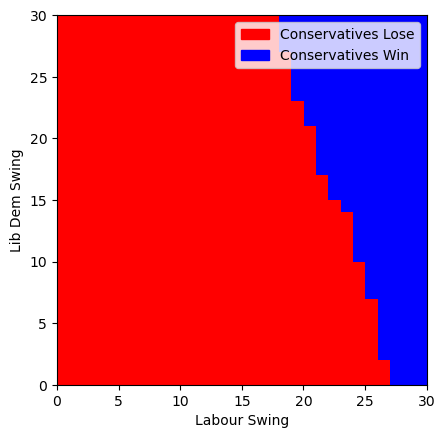

In [183]:
df = pd.DataFrame(FullResultsBool[0], columns = LabMultipliers, index = LDMultipliers)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

colors = ["red", "blue"]
cmap = ListedColormap(colors)

plt.imshow(df, cmap=cmap, extent =[0, 30, 0, 30], origin="lower")

red_patch = mpatches.Patch(color='red', label='Conservatives Lose')
blue_patch = mpatches.Patch(color='blue', label='Conservatives Win')
plt.legend(handles=[red_patch, blue_patch])

plt.xlabel('Labour Swing')
plt.ylabel('Lib Dem Swing')

plt.show()

### Interactive Visualisation
#### Using a widget, interactive visualisation can be achieved whereby users can drag the widget for different shifts from Reform to the Conservatives and see how this impacts the necessary proportions from Labour and the Lib Dems.

In [244]:
import ipywidgets as widgets

def swing_widget(ReformSwing=0):
    df = pd.DataFrame(FullResultsBool[int(ReformSwing/5)], columns = LabMultipliers, index = LDMultipliers)

    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    colors = ["red", "blue"]
    cmap = ListedColormap(colors)

    plt.imshow(df, cmap=cmap, extent =[0, 30, 0, 30], origin="lower")

    plt.xlabel('Labour Proportion')
    plt.ylabel('Lib Dem Proportion')

    red_patch = mpatches.Patch(color='red', label='Conservatives Lose')
    blue_patch = mpatches.Patch(color='blue', label='Conservatives Win')
    plt.legend(handles=[red_patch, blue_patch])

    plt.show()

In [245]:
widgets.interact(swing_widget, ReformSwing=(0,50,5));

interactive(children=(IntSlider(value=0, description='ReformSwing', max=50, step=5), Output()), _dom_classes=(…

### Adjusted Model
#### Finally an adjusted model is made which calculates what happens if Reform gain a proportion of Conservative votes. Like above, this doesn't include the constituencies currently held by the Conservatives but could be easily adjusted to add these. The structure of the model is very similar to above but the Reform vote must be inflated and the original Conservative vote discounted.

In [271]:
ConLabLDRefMixList = []
LabMultiplier = 0.26
LDMultiplier = 0.26
RefMultiplier = -0.25 #Conservative vote lost to Reform

SeatsWon = 0

for i in range(0,505): #Rows left in DF
    LabVote = Targets.iloc[i]['Lab']
    LDVote = Targets.iloc[i]['LD']
    RefVote = Targets.iloc[i]['RUK']
    ConVote = Targets.iloc[i]['Con']
    
    RefVote = RefVote + ConVote*RefMultiplier
    
    Winner = Targets.iloc[i]['First party']
    
    if Winner == 'Lab':
        WinnerVotes = (Targets.iloc[i][Winner])*(1-LabMultiplier)
    elif Winner == 'LD':
        WinnerVotes = (Targets.iloc[i][Winner])*(1-LDMultiplier)
    elif Winner == 'RUK':
        WinnerVotes = ((Targets.iloc[i][Winner])+ (ConVote*RefMultiplier))
    else:
        WinnerVotes = (Targets.iloc[i][Winner])
        
    
    ConLabLDRefMix = LabVote*LabMultiplier + LDVote*LDMultiplier + ConVote*(1+RefMultiplier)
    
    
    MajOverConLabLDRefMix = WinnerVotes - ConLabLDRefMix
                       
    if MajOverConLabLDRefMix < 0 and ConLabLDRefMix > RefVote and ConLabLDRefMix > LDVote*(1-LDMultiplier) and ConLabLDRefMix > LabVote*(1-LabMultiplier):
        SeatsWon = SeatsWon+1

if SeatsWon > int(SeatsNeeded):
    print("Consevatives Win, Seats Gained:", SeatsWon)
else:
    print("Conservatives Lose, Seats Gained:", SeatsWon)

Consevatives Win, Seats Gained: 209
